In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/data7/brandon/research/DA_MVR/sil_consistent_at_inference


In [3]:
import sys
import glob
import pprint
import pickle
import copy

import torch
from torch.nn import functional as F
from PIL import Image
import numpy as np
import trimesh
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.transform import resize
from skimage import img_as_bool
from tqdm import tqdm
from pytorch3d.io import load_objs_as_meshes, load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader
)

from utils import utils
from deformation.deformation_net import DeformationNetwork
from mesh_refiner import MeshRefiner
import deformation.losses as def_losses

In [4]:
DATASET_PATH = "data/test_dataset"
mesh_paths = sorted(glob.glob(os.path.join(DATASET_PATH, "*mesh.obj")))
data_info = []
pred_poses = pickle.load(open(os.path.join(DATASET_PATH, "cached_pred_poses.p"), "rb"))
for mesh_path in mesh_paths:
    instance_number = int(mesh_path.split('/')[-1][:2])
    instance_img_path = os.path.join(DATASET_PATH, "{:02d}_in.jpg".format(instance_number))
    instance_mask_path = os.path.join(DATASET_PATH, "00{:02d}.png".format(instance_number+1))
    img_name = instance_img_path.split('/')[-1]
    simp_mesh_path = mesh_path.replace(".obj","_simp.obj")
    data_info.append({"mesh": mesh_path, "simp_mesh": simp_mesh_path, "input_img": instance_img_path, "mask": instance_mask_path,
                      "azim": pred_poses[img_name]['azim'], "dist": pred_poses[img_name]['dist'], "elev": pred_poses[img_name]['elev']})

{'azim': 151.57894897460938,
 'dist': 1.269230842590332,
 'elev': 9.473684310913086,
 'input_img': 'data/test_dataset/01_in.jpg',
 'mask': 'data/test_dataset/0002.png',
 'mesh': 'data/test_dataset/01_mesh.obj',
 'simp_mesh': 'data/test_dataset/01_mesh_simp.obj'}


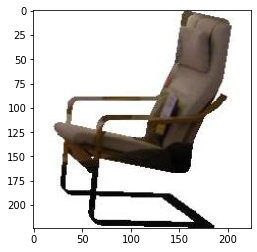

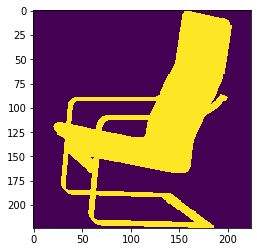

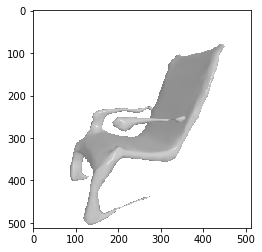

In [5]:
device = torch.device("cuda:0")

for data in data_info[1:2]:
    pprint.pprint(data)
    
    # loading in image, mesh, mask, predicted pose data
    input_image = np.asarray(Image.open(data['input_img']).convert('RGB'))
    with torch.no_grad():
        mesh = utils.load_untextured_mesh(data['simp_mesh'], device)
    mask = Image.open(data['mask']).resize((224,224))
    mask = np.asarray(mask)
    mask = (mask[:,:,3]> 0)
    pred_dist = data['dist']
    pred_elev = data['elev']
    pred_azim = data['azim']
    
    # rendering mesh at predicted pose
    R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim) 
    mesh_rendered_at_pred_pose = utils.render_mesh(mesh, R, T, device)
    
    # visualizing
    plt.imshow(input_image)
    plt.show()
    plt.imshow(mask)
    plt.show()
    plt.imshow(mesh_rendered_at_pred_pose[0, ..., :3].cpu().numpy())
    plt.show()
    

In [15]:
cfg_yaml_path = "configs/default.yaml"
refiner = MeshRefiner(cfg_yaml_path, device)
refined_mesh, loss_info = refiner.refine_mesh(mesh, input_image, mask, pred_dist, pred_elev, pred_azim, False)

/data7/brandon/research/DA_MVR/sil_consistent_at_inference/utils/utils.py:51: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg_special = yaml.load(f)
100%|██████████| 1400/1400 [06:30<00:00,  3.64it/s]


1.269230842590332 9.473684310913086 151.57894897460938
torch.Size([1, 512, 512, 4])


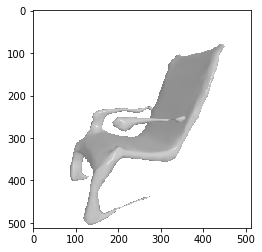

1.269230842590332 9.473684310913086 151.57894897460938
torch.Size([1, 512, 512, 4])


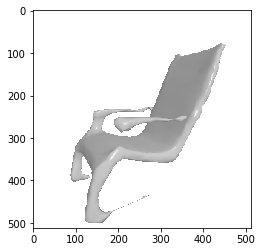

1.269230842590332 9.473684310913086 151.57894897460938
torch.Size([1, 512, 512, 4])


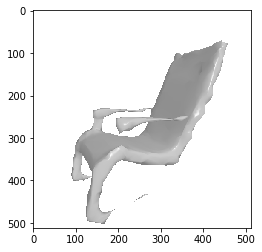

1.269230842590332 9.473684310913086 151.57894897460938
torch.Size([1, 512, 512, 4])


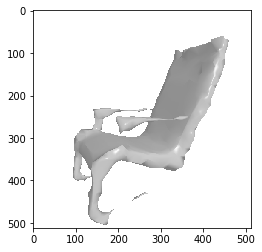

1.269230842590332 9.473684310913086 151.57894897460938
torch.Size([1, 512, 512, 4])


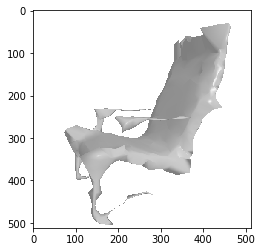

1.269230842590332 9.473684310913086 151.57894897460938
torch.Size([1, 512, 512, 4])


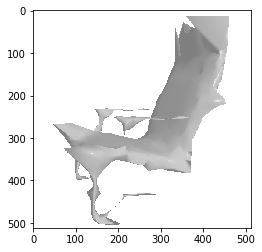

1.269230842590332 9.473684310913086 151.57894897460938
torch.Size([1, 512, 512, 4])


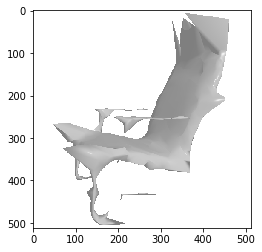

1.269230842590332 9.473684310913086 151.57894897460938
torch.Size([1, 512, 512, 4])


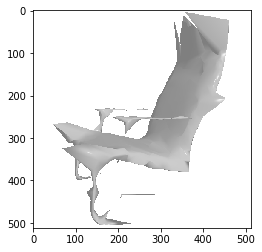

In [10]:
for idx, refined_mesh in enumerate(refined_meshes):
    # rendering mesh at predicted pose
    R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim) 

    print(pred_dist, pred_elev, pred_azim)
    refined_mesh_rendered = utils.render_mesh(refined_mesh, R, T, device)
    print(refined_mesh_rendered.shape)

    # visualizing
    plt.imshow(refined_mesh_rendered[0, ..., :3].detach().cpu().numpy())
    plt.show()

    # saving mesh
    save_obj("notebooks/{}_refined_mesh.obj".format(idx), refined_mesh.verts_packed(), refined_mesh.faces_packed())

1.269230842590332 9.473684310913086 151.57894897460938
torch.Size([1, 512, 512, 4])


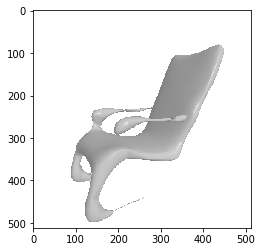

In [16]:
# rendering mesh at predicted pose
R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim) 

print(pred_dist, pred_elev, pred_azim)
refined_mesh_rendered = utils.render_mesh(refined_mesh, R, T, device)
print(refined_mesh_rendered.shape)

# visualizing
plt.imshow(refined_mesh_rendered[0, ..., :3].detach().cpu().numpy())

# saving mesh
save_obj("notebooks/refined_mesh.obj", refined_mesh.verts_packed(), refined_mesh.faces_packed())

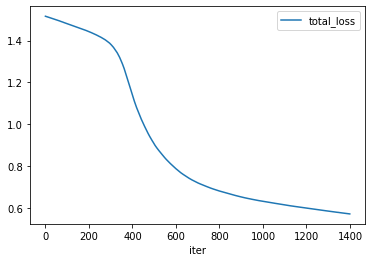

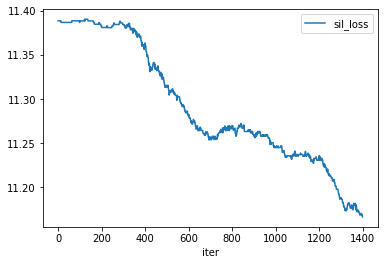

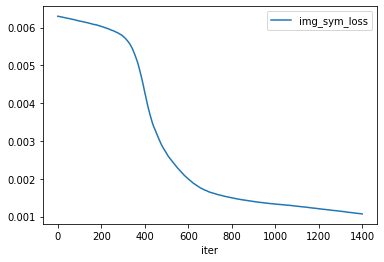

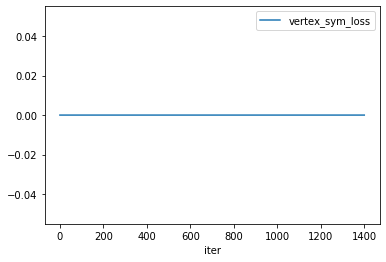

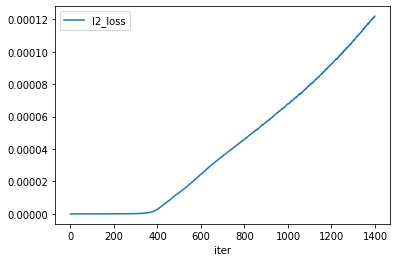

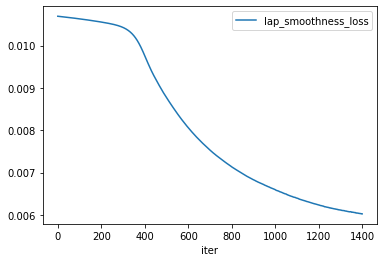

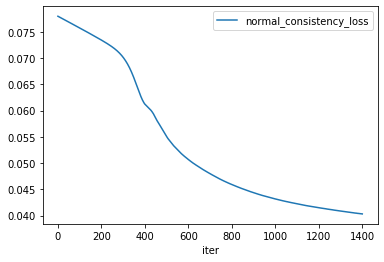

In [17]:
loss_info.plot.line(x='iter', y='total_loss')

loss_info.plot.line(x='iter', y='sil_loss')
loss_info.plot.line(x='iter', y='img_sym_loss')
loss_info.plot.line(x='iter', y='vertex_sym_loss')

loss_info.plot.line(x='iter', y='l2_loss')
loss_info.plot.line(x='iter', y='lap_smoothness_loss')
loss_info.plot.line(x='iter', y='normal_consistency_loss')